## Imports

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [146]:
# Loading pickled dataframe
PICKLE_PATH = "../data/apex"
df = pd.read_pickle(PICKLE_PATH)

In [147]:
# Setting seaborn figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})

Split the time series into a train and split part since we need a feature that we are predicting for. Unlike the typical random selection of train/test splits we can't do that with time series data. Hence we'll take a specific number of value from the beginning of the time series as the train split and the rest will be our test split.

In [148]:
TRAIN_SIZE = 1500

# Splitting the dataframe into train and test sets
df['train'] = df.players[:TRAIN_SIZE]
df['test'] = df.players[TRAIN_SIZE:]

Text(0.5, 1.0, 'Player Activity Train and Test Sets')

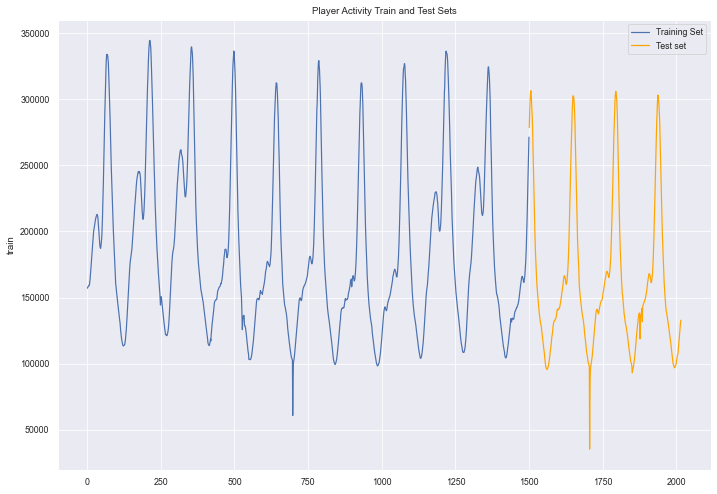

In [149]:
sns.set_theme("paper")
fig = sns.lineplot(data=df.train, label="Training Set")
sns.lineplot(data=df.test, color='orange', label="Test set")

fig.set_title("Player Activity Train and Test Sets")

When forecasting we will need a baseline to compare the performance of our model which we'll use y<sub>n+1</sub> = y<sub>n</sub> model as our naive base model.

In [150]:
# Predictions using the naive model
preds = np.repeat(df.train.dropna()[-1:], df.shape[0]-TRAIN_SIZE)

# All the predictions stored into the dataframe
#df['naive_pred'] = np.repeat(np.nan, TRAIN_SIZE) + preds
df['naive_pred'] = np.nan
df.iloc[TRAIN_SIZE:,-1:] = preds
df

,date,players,twitch_viewers,date_interval,change_in_players,sma,std,day,hour,train,test,naive_pred
1,2022-06-03 03:00:00,157067,69159,0 days 00:10:00,1259,NaN,NaN,Fri,3,157067.0,NaN,NaN
2,2022-06-03 03:10:00,157714,69530,0 days 00:10:00,647,NaN,NaN,Fri,3,157714.0,NaN,NaN
3,2022-06-03 03:20:00,158014,69700,0 days 00:10:00,300,NaN,NaN,Fri,3,158014.0,NaN,NaN
4,2022-06-03 03:30:00,158552,72882,0 days 00:10:00,538,NaN,NaN,Fri,3,158552.0,NaN,NaN
5,2022-06-03 03:40:00,158599,70630,0 days 00:10:00,47,NaN,NaN,Fri,3,158599.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2012,2022-06-17 02:10:00,123712,45020,0 days 00:10:00,3146,173694.795635,3.747205e+09,Fri,2,NaN,123712.0,271460.0
2013,2022-06-17 02:20:00,127175,44328,0 days 00:10:00,3463,173688.967262,3.747713e+09,Fri,2,NaN,127175.0,271460.0
2014,2022-06-17 02:30:00,129576,43811,0 days 00:10:00,2401,173682.773810,3.748221e+09,Fri,2,NaN,129576.0,271460.0
2015,2022-06-17 02:40:00,132040,44776,0 days 00:10:00,2464,173676.510913,3.748704e+09,Fri,2,NaN,132040.0,271460.0


Text(0.5, 1.0, 'Player Activity Train and Test Sets')

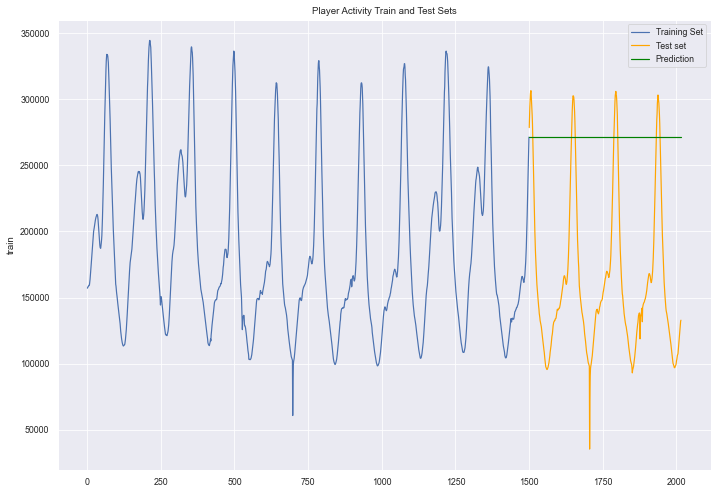

In [151]:
sns.set_theme("paper")
fig = sns.lineplot(data=df.train, label="Training Set")
sns.lineplot(data=df.test, color='orange', label="Test set")
sns.lineplot(data=df.naive_pred, color="green", label="Prediction")

fig.set_title("Player Activity Train and Test Sets")

In [152]:
# Moving Average

In [153]:
# LSTM